# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [11:48:52.993] [89193] 151 logging_/<module>: {logging_yaml: None}

INFO     [11:48:53.545] [89193]  32 api.server_globals/init

DEBUG    [11:48:53.552] [89193]  75 api.server_globals/load: load_search...

INFO     [11:48:53.942] [89193]  79 api.server_globals/load: load_search (took 0.383s)

DEBUG    [11:48:53.951] [89193]  75 api.server_globals/load: load_xc_meta...

INFO     [11:48:54.384] [89193]  79 api.server_globals/load: load_xc_meta (took 0.426s)

DEBUG    [11:48:54.392] [89193]  75 api.server_globals/load: load_feat_info...

INFO     [11:48:54.399] [89193] 110 api.server_globals/load_feat_info

INFO     [11:48:54.406] [89193]  79 api.server_globals/load: load_feat_info (took 0.007s)

WARNING  [11:48:54.412] [89193]  73 api.server_globals/load: load_search_recs [skipped]

INFO     [11:48:54.419] [89193]  34 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

search_recs(**{'cache_type': 'hybrid', 'refresh': True})

INFO     [11:48:54.599] [89193] 601 api.recs/get_search_recs

INFO     [11:48:54.617] [89193]  79 payloads/df_cache_hybrid: Miss: payloads/search_recs-version[8],limit[100],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-fb42447

INFO     [11:48:54.630] [89193] 659 api.recs/_compute_search_recs: {len(sg.xc_meta): 35233, countries_k: na, com_names_k: ca, num_recs: null}

to_paths_sliced: [

] |   0% (100) |  0.0s

to_paths_sliced: [

###############################################################################

] | 100% (100) |  0.1s

audio_metadata: [

] |   0% (100) |  0.0s

audio_metadata: [

] |   0% (100) |  0.1s

audio_metadata: [

] |   0% (100) |  0.4s

audio_metadata: [

######                                                                          

] |   8% (100) |  3.9s

audio_metadata: [

############                                                                    

] |  16% (100) |  4.1s

audio_metadata: [

##################                                                              

] |  23% (100) |  4.3s

audio_metadata: [

########################                                                        

] |  31% (100) |  4.4s

audio_metadata: [

#############################                                                   

] |  36% (100) |  4.6s

audio_metadata: [

#################################                                               

] |  42% (100) |  4.7s

audio_metadata: [

####################################                                            

] |  46% (100) |  4.9s

audio_metadata: [

########################################                                        

] |  51% (100) |  5.0s

audio_metadata: [

##############################################                                  

] |  57% (100) |  5.2s

audio_metadata: [

##################################################                              

] |  63% (100) |  5.3s

audio_metadata: [

######################################################                          

] |  68% (100) |  5.5s

audio_metadata: [

############################################################                    

] |  75% (100) |  5.6s

audio_metadata: [

################################################################                

] |  81% (100) |  5.8s

audio_metadata: [

#####################################################################           

] |  87% (100) |  6.0s

audio_metadata: [

#########################################################################       

] |  92% (100) |  6.1s

audio_metadata: [

################################################################################

] | 100% (100) |  6.3s

feat: [

] |   0% (100) |  0.0s

feat: [

#                                                                                         

] |   2% (100) |  0.1s

feat: [

#####                                                                                     

] |   6% (100) |  0.2s

feat: [

########                                                                                  

] |   9% (100) |  0.3s

feat: [

###########                                                                               

] |  13% (100) |  0.4s

feat: [

##############                                                                            

] |  16% (100) |  0.5s

feat: [

##################                                                                        

] |  20% (100) |  0.6s

feat: [

####################                                                                      

] |  23% (100) |  0.7s

feat: [

#########################                                                                 

] |  28% (100) |  0.9s

feat: [

###########################                                                               

] |  31% (100) |  1.0s

feat: [

###############################                                                           

] |  35% (100) |  1.1s

feat: [

###################################                                                       

] |  39% (100) |  1.2s

feat: [

######################################                                                    

] |  43% (100) |  1.3s

feat: [

##########################################                                                

] |  47% (100) |  1.4s

feat: [

#############################################                                             

] |  50% (100) |  1.5s

feat: [

##################################################                                        

] |  56% (100) |  1.6s

feat: [

######################################################                                    

] |  60% (100) |  1.7s

feat: [

########################################################                                  

] |  63% (100) |  1.8s

feat: [

############################################################                              

] |  67% (100) |  1.9s

feat: [

###############################################################                           

] |  71% (100) |  2.0s

feat: [

##################################################################                        

] |  74% (100) |  2.1s

feat: [

######################################################################                    

] |  78% (100) |  2.2s

feat: [

#########################################################################                 

] |  82% (100) |  2.3s

feat: [

#############################################################################             

] |  86% (100) |  2.4s

feat: [

#################################################################################         

] |  90% (100) |  2.5s

feat: [

###################################################################################       

] |  93% (100) |  2.6s

feat: [

#######################################################################################   

] |  97% (100) |  2.7s

feat: [

##########################################################################################

] | 100% (100) |  2.8s

f_preds: [

] |   0% (100) |  0.0s

f_preds: [

] |   0% (100) |  0.1s

f_preds: [

] |   0% (100) |  0.2s

f_preds: [

] |   0% (100) |  0.3s

f_preds: [

#######################################################################################

] | 100% (100) |  0.5s

rec_spectro_bytes:   0%|                                                                       | 0/100 [00:00<?, ?it/s]

rec_spectro_bytes:   2%|█▎                                                             | 2/100 [00:00<00:06, 15.40it/s]

rec_spectro_bytes:   5%|███▏                                                           | 5/100 [00:00<00:05, 17.96it/s]

rec_spectro_bytes:   7%|████▍                                                          | 7/100 [00:00<00:05, 17.74it/s]

rec_spectro_bytes:   9%|█████▋                                                         | 9/100 [00:00<00:05, 17.92it/s]

rec_spectro_bytes:  11%|██████▊                                                       | 11/100 [00:00<00:04, 17.90it/s]

rec_spectro_bytes:  13%|████████                                                      | 13/100 [00:00<00:04, 17.89it/s]

rec_spectro_bytes:  15%|█████████▎                                                    | 15/100 [00:00<00:04, 17.78it/s]

rec_spectro_bytes:  17%|██████████▌                                                   | 17/100 [00:00<00:04, 17.81it/s]

rec_spectro_bytes:  19%|███████████▊                                                  | 19/100 [00:01<00:04, 17.85it/s]

rec_spectro_bytes:  21%|█████████████                                                 | 21/100 [00:01<00:04, 17.73it/s]

rec_spectro_bytes:  23%|██████████████▎                                               | 23/100 [00:01<00:04, 17.76it/s]

rec_spectro_bytes:  25%|███████████████▌                                              | 25/100 [00:01<00:04, 17.70it/s]

rec_spectro_bytes:  28%|█████████████████▎                                            | 28/100 [00:01<00:03, 18.01it/s]

rec_spectro_bytes:  30%|██████████████████▌                                           | 30/100 [00:01<00:03, 17.91it/s]

rec_spectro_bytes:  32%|███████████████████▊                                          | 32/100 [00:01<00:03, 17.86it/s]

rec_spectro_bytes:  34%|█████████████████████                                         | 34/100 [00:01<00:03, 17.80it/s]

rec_spectro_bytes:  36%|██████████████████████▎                                       | 36/100 [00:02<00:03, 17.76it/s]

rec_spectro_bytes:  38%|███████████████████████▌                                      | 38/100 [00:02<00:03, 17.70it/s]

rec_spectro_bytes:  40%|████████████████████████▊                                     | 40/100 [00:02<00:03, 17.66it/s]

rec_spectro_bytes:  42%|██████████████████████████                                    | 42/100 [00:02<00:03, 17.60it/s]

rec_spectro_bytes:  45%|███████████████████████████▉                                  | 45/100 [00:02<00:03, 17.72it/s]

rec_spectro_bytes:  47%|█████████████████████████████▏                                | 47/100 [00:02<00:02, 17.71it/s]

rec_spectro_bytes:  49%|██████████████████████████████▍                               | 49/100 [00:02<00:02, 17.72it/s]

rec_spectro_bytes:  51%|███████████████████████████████▌                              | 51/100 [00:02<00:02, 17.75it/s]

rec_spectro_bytes:  55%|██████████████████████████████████                            | 55/100 [00:02<00:02, 18.36it/s]

rec_spectro_bytes:  58%|███████████████████████████████████▉                          | 58/100 [00:03<00:02, 18.37it/s]

rec_spectro_bytes:  61%|█████████████████████████████████████▊                        | 61/100 [00:03<00:02, 18.39it/s]

rec_spectro_bytes:  64%|███████████████████████████████████████▋                      | 64/100 [00:03<00:01, 18.25it/s]

rec_spectro_bytes:  66%|████████████████████████████████████████▉                     | 66/100 [00:03<00:01, 18.19it/s]

rec_spectro_bytes:  68%|██████████████████████████████████████████▏                   | 68/100 [00:03<00:01, 18.15it/s]

rec_spectro_bytes:  70%|███████████████████████████████████████████▍                  | 70/100 [00:03<00:01, 18.05it/s]

rec_spectro_bytes:  72%|████████████████████████████████████████████▋                 | 72/100 [00:04<00:01, 17.96it/s]

rec_spectro_bytes:  74%|█████████████████████████████████████████████▉                | 74/100 [00:04<00:01, 17.97it/s]

rec_spectro_bytes:  76%|███████████████████████████████████████████████               | 76/100 [00:04<00:01, 17.93it/s]

rec_spectro_bytes:  78%|████████████████████████████████████████████████▎             | 78/100 [00:04<00:01, 17.86it/s]

rec_spectro_bytes:  81%|██████████████████████████████████████████████████▏           | 81/100 [00:04<00:01, 17.95it/s]

rec_spectro_bytes:  83%|███████████████████████████████████████████████████▍          | 83/100 [00:04<00:00, 17.94it/s]

rec_spectro_bytes:  85%|████████████████████████████████████████████████████▋         | 85/100 [00:04<00:00, 17.93it/s]

rec_spectro_bytes:  87%|█████████████████████████████████████████████████████▉        | 87/100 [00:04<00:00, 17.91it/s]

rec_spectro_bytes:  89%|███████████████████████████████████████████████████████▏      | 89/100 [00:04<00:00, 17.91it/s]

rec_spectro_bytes:  91%|████████████████████████████████████████████████████████▍     | 91/100 [00:05<00:00, 17.94it/s]

rec_spectro_bytes:  93%|█████████████████████████████████████████████████████████▋    | 93/100 [00:05<00:00, 17.90it/s]

rec_spectro_bytes:  95%|██████████████████████████████████████████████████████████▉   | 95/100 [00:05<00:00, 17.90it/s]

rec_spectro_bytes:  97%|████████████████████████████████████████████████████████████▏ | 97/100 [00:05<00:00, 17.90it/s]

rec_spectro_bytes:  99%|█████████████████████████████████████████████████████████████▍| 99/100 [00:05<00:00, 17.86it/s]

rec_spectro_bytes: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.87it/s]

INFO     [11:49:11.602] [89193] 925 api.recs/recs_featurize_spectro_bytes: [5.605s]

audio_bytes: [

] |   0% (100) |  0.0s

audio_bytes: [

###################################################################################

] | 100% (100) |  0.1s

INFO     [11:49:11.753] [89193] 999 api.recs/recs_featurize_audio_bytes: [0.133s]

INFO     [11:49:11.763] [89193] 687 api.recs/recs_featurize_pre_rank: batches (1/1) [17.120s]

INFO     [11:49:11.778] [89193]  85 payloads/df_cache_hybrid: Compute: search_recs [17.149s]

INFO     [11:49:11.815] [89193] 103 payloads/df_cache_hybrid: Miss: Inferred feat_cols['f_preds', 'feat']

INFO     [11:49:12.371] [89193] 111 payloads/df_cache_hybrid: Miss: Write api/lite.parquet [164.0 kB, 0.545s]

INFO     [11:49:12.402] [89193] 120 payloads/df_cache_hybrid: Miss: Write api/bytes-audio_bytes.parquet [4.0 MB, 0.014s]

INFO     [11:49:12.420] [89193] 120 payloads/df_cache_hybrid: Miss: Write api/bytes-spectro_bytes.parquet [1.1 MB, 0.005s]

INFO     [11:49:12.433] [89193] 127 payloads/df_cache_hybrid: Miss: Write api/feat-f_preds.npy: float32 [132.5 kB, 0.002s]

INFO     [11:49:12.447] [89193] 127 payloads/df_cache_hybrid: Miss: Write api/feat-feat.npy: float32 [600.1 kB, 0.002s]

INFO     [11:49:12.456] [89193] 145 payloads/df_cache_hybrid: Miss: search_recs [0.665s]

INFO     [11:49:12.500] [89193] 244 payloads/df_cache_hybrid: Mobile: Add columns for mobile [0.011s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (53) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

###############################################################

] | 100% (53) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (100) |  0.0s

Mobile: Write files: audio_bytes: [

############################################################# 

] |  99% (100) |  0.1s

Mobile: Write files: audio_bytes: [

##############################################################

] | 100% (100) |  0.2s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (53) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

#############################################################

] | 100% (53) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (100) |  0.0s

Mobile: Write files: spectro_bytes: [

############################################################

] | 100% (100) |  0.1s

INFO     [11:49:13.394] [89193] 286 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [0.148s]

INFO     [11:49:13.413] [89193] 298 payloads/df_cache_hybrid: Mobile: Norm feat col: f_preds [0.003s]

INFO     [11:49:13.429] [89193] 329 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (100) [0.001s]

INFO     [11:49:13.442] [89193] 329 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (100) [0.001s]

INFO     [11:49:14.200] [89193] 361 payloads/df_cache_hybrid: Mobile: Write mobile-version[1]/search_recs/search_recs.sqlite3 [499.7 kB, 0.746s]

INFO     [11:49:14.216] [89193] 371 payloads/df_cache_hybrid: Mobile: Write mobile-version[1]/search_recs/server-config.json [2.3 kB, 0.001s]

INFO     [11:49:14.236] [89193] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.D.npy [420.1 kB, 0.006s]

INFO     [11:49:14.249] [89193] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.pca.mean_.npy [1.4 kB, 0.001s]

INFO     [11:49:14.260] [89193] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.pca.components_.npy [134.5 kB, 0.001s]

INFO     [11:49:14.273] [89193] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.pca.explained_variance_.npy [968 B, 0.001s]

INFO     [11:49:14.291] [89193] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/classifier_._coef_arr.npy [4.0 MB, 0.003s]

INFO     [11:49:14.307] [89193] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/classifier_._intercept_arr.npy [2.8 kB, 0.001s]

INFO     [11:49:14.318] [89193] 446 payloads/df_cache_hybrid: Mobile: Write mobile-version[1]/search_recs/models/search.json [4.9 kB, 0.091s]

INFO     [11:49:14.325] [89193] 446 payloads/df_cache_hybrid: Mobile: Write payload [1.859s]

,dir,file,size,frac
5,api,TOTAL,6007805,1.000
1,api,api/bytes-audio_bytes.parquet,4030138,0.671
2,api,api/bytes-spectro_bytes.parquet,1081058,0.180
4,api,api/feat-feat.npy: float32,600128,0.100
0,api,api/lite.parquet,163953,0.027
3,api,api/feat-f_preds.npy: float32,132528,0.022
9,mobile-version[1],TOTAL,5939200,1.000
6,mobile-version[1],mobile-version[1]/search_recs/audio/,4182016,0.704
7,mobile-version[1],mobile-version[1]/search_recs/spectro/,1257472,0.212
8,mobile-version[1],mobile-version[1]/search_recs/search_recs.sqlite3,499712,0.084


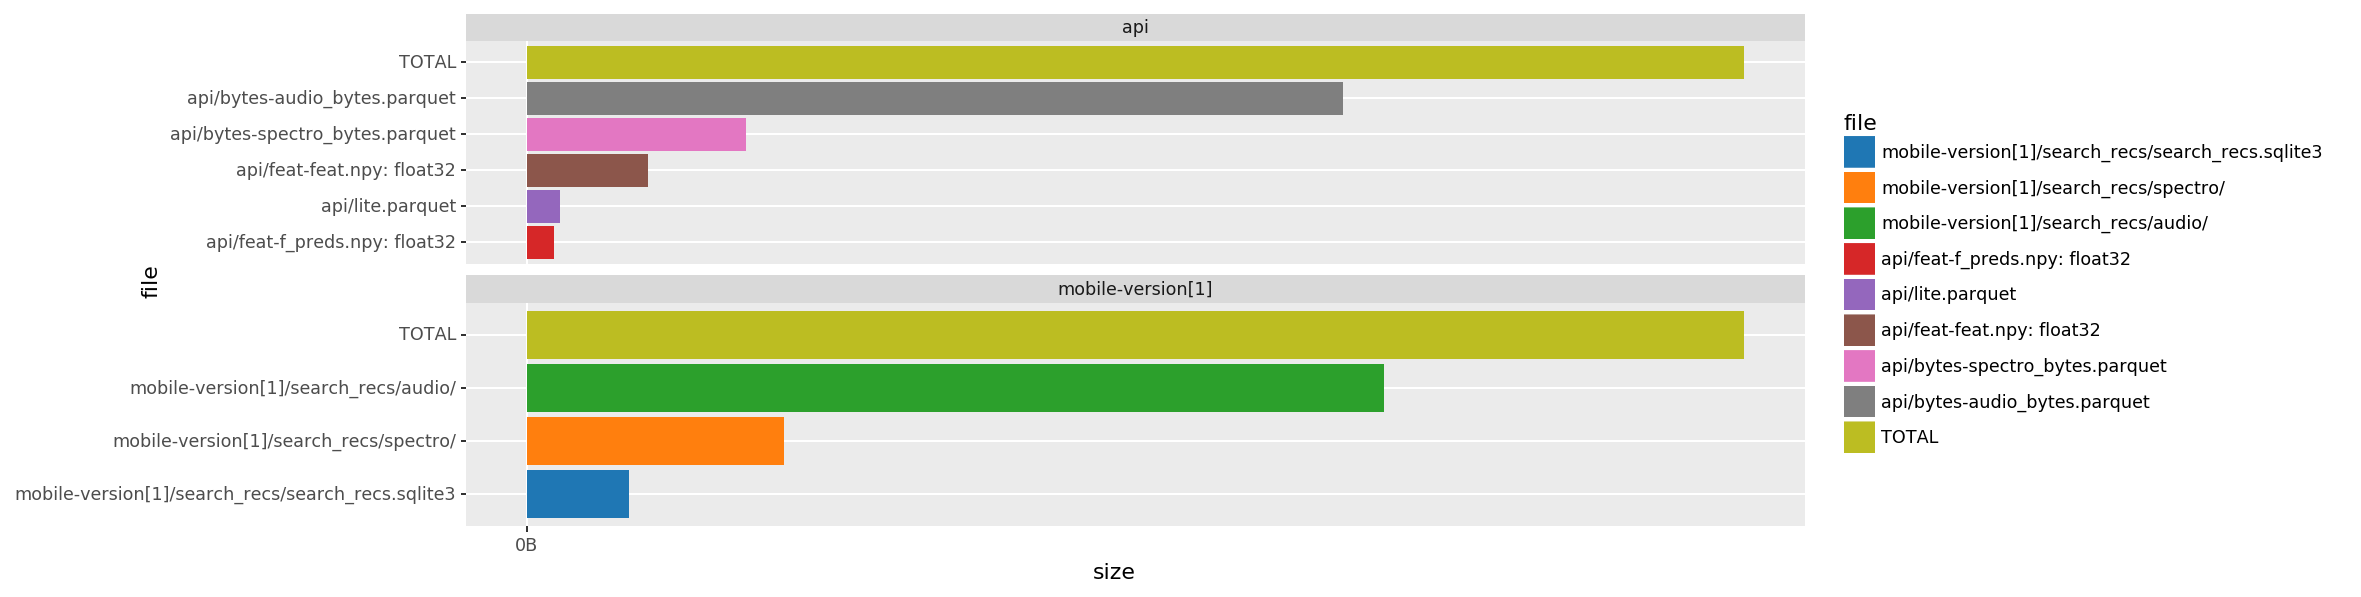

<ggplot: (-9223372036514837188)>

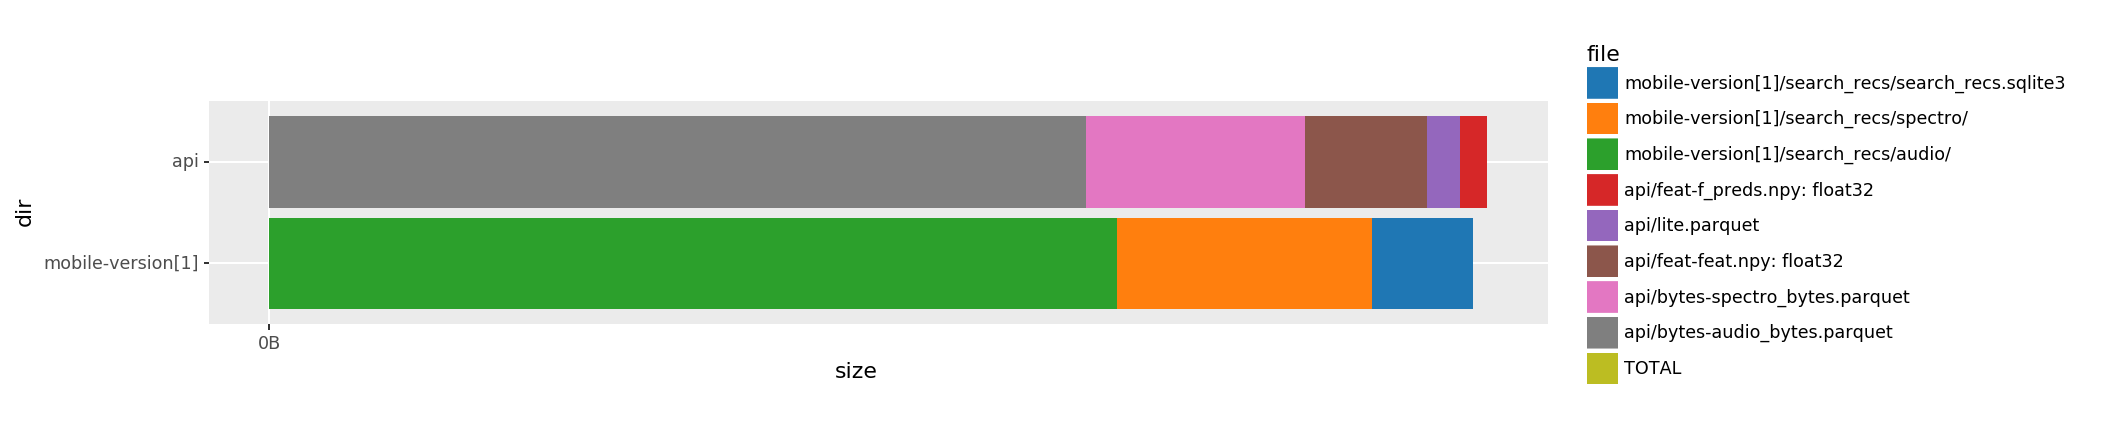

<ggplot: (-9223372036514526832)>

,size,type,0
xc_id,36,int,416421
feat,6104,ndarray,[ 2.872e-02 -2.151e-02 -3.703e-01 -2.697e-03 -1.268e-02 8.456e-02 2.277e-01 1.489e-01 -1.414e-01 9.737e-02 1.356e-01 -2.400e-01 5.771e-02 1.620e-02 1.130e-01 4.74...
f_preds,104,ndarray,[4.138e-04 1.147e-03 4.068e-07 2.627e-08 9.826e-03 9.456e-07 2.984e-07 4.845e-04 8.321e-08 3.356e-04 2.281e-04 2.211e-07 9.809e-05 9.184e-04 2.278e-05 3.288e-03 1.257e-04 ...
background,88,list,"['Killdeer (Charadrius vociferus)', 'Common Gallinule (Gallinula galeata)']"
background_species,80,list,"['KILL', 'COGA']"


In [ ]:
with ExitStack() as stack:
    stack.enter_context(cache_control(refresh=True))
    log_levels({
        'payloads': 'INFO',
        # 'payloads': 'DEBUG',
    })
    kwargss = [
        dict(cache_type='hybrid', refresh=True),  # Simulate cache miss
        # dict(cache_type='hybrid'),                # Simulate cache hit
    ]
    search_recss = []
    for i, kwargs in enumerate(kwargss):
        if i > 0: print()
        print(f'search_recs(**{kwargs})')
        get_search_recs.cache_clear()
        search_recs = get_search_recs(**kwargs,
            write_mobile_payload=True,
            plot_sizes=True,
        )
        search_recss.append(search_recs)
        display(search_recs
            [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
            [2:3].reset_index(drop=True).T
            .pipe(df_assign_first,
                size=lambda df: df.T.memory_usage(deep=True),
                type=lambda df: df[0].map(lambda x: type(x).__name__),
            )
        )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)